First, we install simpy library. Then, import the necessary libraries.

In [1]:
%pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import simpy
from scipy import stats

Then, we define necessary state variables for the simulation

In [3]:
# Number of jobs in the simulation
numberOfJobs = 10020

# Number of servers available for processing jobs
numberOfServers = 2

# Minimum and maximum interarrival time between jobs
interarrivalTimeMin = 6.16
interarrivalTimeMax = 7.25

# Utilization rate of the servers
utilizationRate = 0.8

# Calculate the service rate based on interarrival time and utilization rate
serviceRate = (1 / ((interarrivalTimeMin + interarrivalTimeMax) / 2)) / (utilizationRate * numberOfServers)

# Number of repetitions for running the simulation
numberOfRepetitions = 10

# Time spent by a customer while waiting in the queue for the operator (Queue waiting time Wq)
queueWaitingTimes = []

# Duration of the conversation between the customer and the operator (Service time)
serviceTimes = []

# Total waiting time of a customer (Wq + Service time), also known as Sojourn time
totalWaitingTimes = []

# Keeps the sum of waiting times of all customers in each simulation run
totalTimeWaitedForAllCustomers = []

# Keep statistics for calculating average number of jobs in the system (L(t))
averageNumberOfJobsInTheSystem = []

# Keep the time when warmup period ends. 
simulationBeginTime = 0


Then, we create the job class for handling simulation thanks to simpy

In [4]:
class Job(object):
    def __init__(self, env, operator, jobNumber, repetition):
        self.env = env
        self.operator = operator
        self.jobNumber = jobNumber - 10000
        self.repetition = repetition  # Which simulation run it is in (first, tenth, etc.)
        self.arrivalTime = self.env.now
        self.action = env.process(self.requestServer())

    def requestServer(self):
        # Request the operator resource (server)
        with self.operator.request() as req:
            yield req
            # Calculate the queue waiting time for the last 20 jobs
            if(self.jobNumber >= 0):
                queueWaitingTimes[self.jobNumber] = self.env.now - self.arrivalTime
            yield self.env.process(self.getService())

    def getService(self):
        # Generate a random service duration based on the service rate
        global simulationBeginTime

        if(self.jobNumber == 0):
            simulationBeginTime = self.env.now

        duration = random.expovariate(serviceRate)
        yield self.env.timeout(duration)
        # Store the service time 
        if(self.jobNumber >= 0):
            serviceTimes[self.jobNumber] = duration
        # Calculate the total waiting time for the customer
        if(self.jobNumber >= 0):
            totalWaitingTimes[self.jobNumber] = self.env.now - self.arrivalTime
        # Update the total time waited for all customers in this simulation run
        if(self.jobNumber >= 0):
            totalTimeWaitedForAllCustomers[repetition] += totalWaitingTimes[self.jobNumber]
        # Update the average number of jobs in the system
        if(self.jobNumber >= 0):
            averageNumberOfJobsInTheSystem[self.jobNumber] += totalTimeWaitedForAllCustomers[repetition] / (self.env.now - simulationBeginTime)

Then, we create necessary numbers of jobs for our simulation

In [5]:
def jobGenerator(env, operator, repetition):
    # Generate jobs with random interarrival times
    for jobNumber in range(numberOfJobs):
        yield env.timeout(random.uniform(interarrivalTimeMin, interarrivalTimeMax))
        Job(env, operator, jobNumber, repetition)


Then, we initialize necessary state variables for our simulation

In [6]:
# Create empty arrays to store data for each repetition
queueWaitingTimesAll = np.zeros((numberOfRepetitions, numberOfJobs - 10000))
serviceTimesAll = np.zeros((numberOfRepetitions, numberOfJobs -  10000))
totalWaitingTimesAll = np.zeros((numberOfRepetitions, numberOfJobs - 10000))
totalTimeWaitedForAllCustomersAll = np.zeros((numberOfRepetitions, numberOfJobs - 10000))
averageNumberOfJobsInTheSystemAll = np.zeros((numberOfRepetitions, numberOfJobs - 10000))

Then, we run the simulation as follows

In [7]:
################## RUN THE SIMULATION BELOW ##########################

# Run the simulation multiple times
for repetition in range(numberOfRepetitions):
    # Seed the random number generator for reproduconfidenceIntervalbility
    random.seed(random.randint(0, 2**32 - 1))

    # Initialize arrays for storing simulation data
    queueWaitingTimes = np.zeros(numberOfJobs - 10000)
    serviceTimes = np.zeros(numberOfJobs - 10000)
    totalWaitingTimes = np.zeros(numberOfJobs - 10000)
    totalTimeWaitedForAllCustomers = np.zeros(numberOfJobs - 10000)
    averageNumberOfJobsInTheSystem = np.zeros(numberOfJobs - 10000)

    env = simpy.Environment()
    operator = simpy.Resource(env, capacity=numberOfServers)
    env.process(jobGenerator(env, operator, repetition))
    env.run()

    # Store data for each repetition in the respective arrays
    queueWaitingTimesAll[repetition] = queueWaitingTimes
    serviceTimesAll[repetition] = serviceTimes
    totalWaitingTimesAll[repetition] = totalWaitingTimes
    totalTimeWaitedForAllCustomersAll[repetition] = totalTimeWaitedForAllCustomers
    averageNumberOfJobsInTheSystemAll[repetition] = averageNumberOfJobsInTheSystem


################## RUN THE SIMULATION ABOVE ##########################

Then, we calculate the necessary results by the state variables

In [8]:
################## CALCULATE RESPONSES BELOW #########################

# Calculate ensemble averages
ensembleQueueWaitingTimes = np.mean(queueWaitingTimesAll, axis=0)
ensembleServiceTimes = np.mean(serviceTimesAll, axis=0)
ensembleTotalWaitingTimes = np.mean(totalWaitingTimesAll, axis=0)
ensembleAverageNumberOfJobsInTheSystem = np.mean(averageNumberOfJobsInTheSystemAll, axis=0)
ensembleTotalTimeWaitedForAllCustomers = np.mean(totalTimeWaitedForAllCustomers, axis=0)

# Calculate confidence intervals
confidenceLevel = 0.95
alpha = 1 - confidenceLevel
nRepetitions = numberOfRepetitions
tValue = np.abs(stats.t.ppf(alpha / 2, df=nRepetitions - 1))
queueWaitingTimesStd = np.std(queueWaitingTimesAll, axis=0)
serviceTimesStd = np.std(serviceTimesAll, axis=0)
totalWaitingTimesStd = np.std(totalWaitingTimesAll, axis=0)
averageNumberOfJobsInTheSystemStd = np.std(averageNumberOfJobsInTheSystemAll, axis=0)
confidenceIntervalQueueWaitingTimes = tValue * (queueWaitingTimesStd / np.sqrt(nRepetitions))
confidenceIntervalServiceTimes = tValue * (serviceTimesStd / np.sqrt(nRepetitions))
confidenceIntervalTotalWaitingTimes = tValue * (totalWaitingTimesStd / np.sqrt(nRepetitions))
confidenceIntervalAverageNumberOfJobsInTheSystem = tValue * (averageNumberOfJobsInTheSystemStd / np.sqrt(nRepetitions))

Then, at the end, we plot the results by the following code

[ 9.21338246  5.45083154  4.80473376 14.89780094  1.88501466  0.74036622
  4.77337839  7.81605133  8.52886811 24.7464544   4.04821529  0.49913981
 27.34446332 15.15884554 16.50655763 13.01964868 12.88743597  3.26119336
  7.55636968 14.50053843]


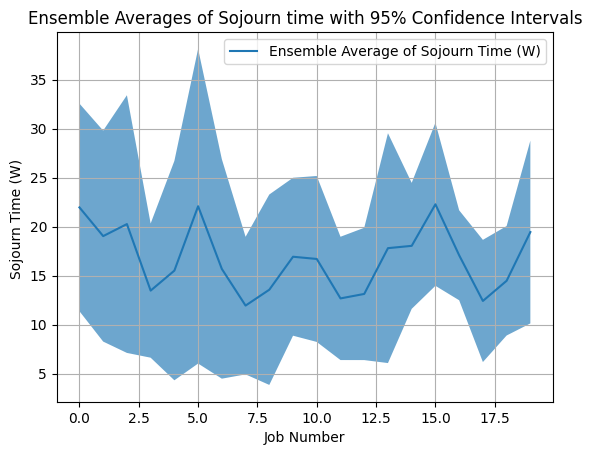

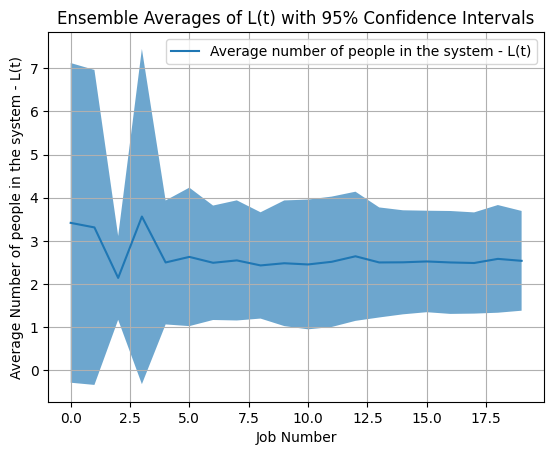

In [9]:
print(serviceTimes)

# Plot the ensemble averages with confidence intervals
plt.figure()

plt.plot(ensembleTotalWaitingTimes, label="Ensemble Average of Sojourn Time (W)")
plt.fill_between(range(numberOfJobs - 10000), ensembleTotalWaitingTimes - confidenceIntervalTotalWaitingTimes,
                 ensembleTotalWaitingTimes + confidenceIntervalTotalWaitingTimes, alpha=0.65)

plt.xlabel('Job Number')
plt.ylabel('Sojourn Time (W) ')
plt.title('Ensemble Averages of Sojourn time with 95% Confidence Intervals')
plt.legend()
plt.grid(True)


plt.figure()

plt.plot(ensembleAverageNumberOfJobsInTheSystem, label="Average number of people in the system - L(t)")
plt.fill_between(range(numberOfJobs - 10000), ensembleAverageNumberOfJobsInTheSystem - confidenceIntervalAverageNumberOfJobsInTheSystem,
                 ensembleAverageNumberOfJobsInTheSystem + confidenceIntervalAverageNumberOfJobsInTheSystem, alpha=0.65)

plt.xlabel('Job Number')
plt.ylabel('Average Number of people in the system - L(t)')
plt.title('Ensemble Averages of L(t) with 95% Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()